# 代码实现

In [1]:
from utils import *

## 角点响应函数（Corner Response Function）

角点响应函数是角点检测算法中的核心计算公式，用于判断图像中的一个点是否为角点。

### 数学定义

角点响应函数定义为：



$$R = \det(M) - k \cdot (\text{trace}(M))^2$$

其中：
- $M$ 是基于图像梯度计算得到的2×2矩阵（通常称为结构张量或自相关矩阵）
- $\det(M)$ 是矩阵的行列式
- $\text{trace}(M)$ 是矩阵的迹（对角线元素之和）
- $k$ 是经验常数，通常取值在0.04-0.06之间

### 物理意义

1. **行列式 $\det(M)$**：表示局部区域梯度变化的"体积"，当图像在两个方向上都有明显变化时（角点特性）值较大
  
2. **迹 $\text{trace}(M)$**：表示局部区域梯度变化的"强度"，边缘和角点都可能有较大值

3. **响应值 $R$**：
   - $R$ 较大正值：表示可能是角点
   - $R$ 较大负值：表示可能是边缘
   - $R$ 接近0：表示可能是平坦区域

### 角点判定

基于响应函数值 $R$，通常设定一个阈值 $T$，当 $R > T$ 时，认为该点是角点。

在实际应用中，常采用非极大值抑制等后处理技术，以获得更精确的角点位置。

In [17]:
class CornerNotebook:
    def __init__(self):
        """
        初始化角点检测类
        """
        pass

    # 计算角点响应函数
    def reponseFunc(self,M):
        """
        计算角点响应函数
        :param M: 2x2矩阵
        :return: 角点响应值
        """
        det = np.linalg.det(M) # 计算行列式
        trace = np.trace(M) # 计算迹
        k = 0.04 # Harris角点检测的常数

        response = det - k * (trace ** 2) # 计算角点响应函数
        return response

    # Harris角点检测
    def harris_corners(self, src, NMS=False):

        # 获得输入图像的长宽
        h, w = src.shape[:2]

        # 将图像转为灰度图像
        gray_image = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

        # 初始化角点矩阵
        cornerPoint = np.zeros_like(gray_image, dtype=np.float32)

        # 计算图像沿横轴和纵轴的梯度
        grad = np.zeros((h, w, 2), dtype=np.float32)

        # x方向梯度
        grad[:,:,0] = cv2.Sobel(gray_image, cv2.CV_16S, 1, 0)

        # y方向梯度
        grad[:,:,1] = cv2.Sobel(gray_image, cv2.CV_16S, 0, 1)

        # 计算黑塞矩阵内元素的值，此时的值是求和的结果，即M矩阵的元素
        Ixx = grad[:,:,0]**2
        Iyy = grad[:,:,1]**2
        Ixy = grad[:,:,0]*grad[:,:,1]

        # 计算窗口内黑塞矩阵元素的值，窗函数使用高斯函数
        Ixx = cv2.GaussianBlur(Ixx, (3,3), sigmaX=2)
        Iyy = cv2.GaussianBlur(Iyy, (3,3), sigmaX=2)
        Ixy = cv2.GaussianBlur(Ixy, (3,3), sigmaX=2)

        for i in range(gray_image.shape[0]):
            for j in range(gray_image.shape[1]):

                # 构建M矩阵
                structure_matrix = [[Ixx[i][j],Ixy[i][j]],
                                    [Ixy[i][j],Iyy[i][j]]]
                
                # 计算角点响应函数
                R = self.reponseFunc(structure_matrix)
                cornerPoint[i][j] = R

        # 非最大抑制
        corners = np.zeros_like(gray_image, dtype=np.float32)
        threshold = 0.01

        # 返回所有角点响应的最大值
        maxValue = np.max(cornerPoint)

        # 我们将角点响应函数的阈值设定为  threshold * maxValue

        for i in range(cornerPoint.shape[0]):
            for j in range(cornerPoint.shape[1]):

                # 如果进行NMS操作
                if NMS:
                    # 当前角点响应值大于阈值，同时也是邻居周围的最大值
                    if cornerPoint[i][j] > threshold * maxValue and \
                        cornerPoint[i][j] == np.max(\
                            cornerPoint[max(0,i-1):min(i+1, h-1),
                            max(0,j-1):min(j+1, w-1)]):

                            corners[i][j] = 255
                else:
                    # 如果当前角点响应值大于阈值
                    if cornerPoint[i][j] > threshold * maxValue:
                        corners[i][j] = 255
        # 返回 角点响应矩阵
        return corners


# Harris 角点检测算法

Harris 角点检测是一种经典的计算机视觉算法，用于识别图像中的角点。角点通常是两条边的交点，在图像中具有显著的梯度变化。

## 算法原理

Harris 角点检测基于以下观察：当窗口在图像上移动时，角点区域在所有方向上都会有显著的强度变化。

### 主要步骤

1. **图像预处理**
    - 将彩色图像转换为灰度图像，简化计算

2. **计算图像梯度**
    - 使用 Sobel 算子计算 x 方向和 y 方向的梯度 (Ix, Iy)

3. **构建结构张量 (Structure Tensor)**
    - 计算梯度的乘积：Ixx = Ix²，Iyy = Iy²，Ixy = Ix·Iy
    - 对这些乘积应用高斯模糊，形成窗口加权
    - 对每个像素位置构建 2×2 结构矩阵 M = [[Ixx, Ixy], [Ixy, Iyy]]

4. **计算角点响应函数**
    - 使用公式 R = det(M) - k·(trace(M))²
    - 其中 k 是经验常数（通常为 0.04-0.06）

5. **角点判定**
    - 设定阈值，R 值大于阈值的点被识别为角点
    - 可选择应用非极大值抑制(NMS)，提高角点定位精度

## 角点响应函数解释

- **R > 0 且较大**：表示可能是角点（两个方向都有显著变化）
- **R < 0**：表示可能是边缘（仅一个方向有显著变化）
- **|R| 接近 0**：表示平坦区域（各方向变化都不明显）

## 算法优势

1. 旋转不变性 - 即使图像旋转，同一个角点仍能被检测到
2. 部分光照不变性 - 对光照变化有一定的鲁棒性
3. 噪声抗性 - 通过高斯平滑减少噪声影响

Harris 角点检测至今仍被广泛应用于特征提取、图像拼接、目标跟踪等计算机视觉任务中。

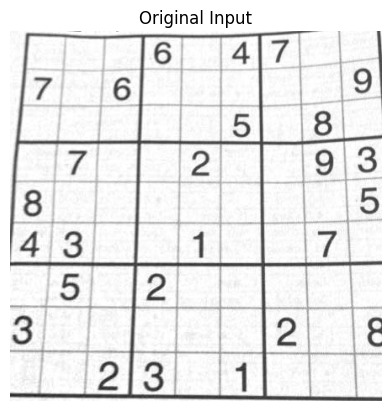

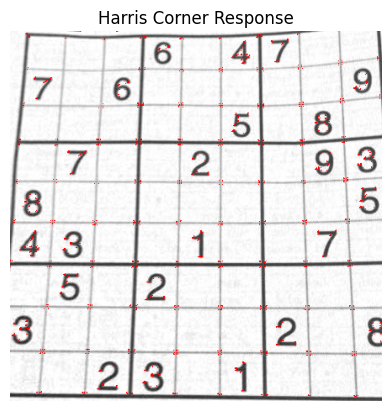

In [19]:
img = cv2.imread('sudoku.png')

plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.title('Original Input')
plt.show()

corner_detector = CornerNotebook()
response = corner_detector.harris_corners(img, NMS=True)
img[response == 255] = [0,0,255]
plt.imshow(img[:,:,::-1])
plt.axis('off')
plt.title('Harris Corner Response')
plt.show()